In [54]:
# Importing libraries
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import numpy as np
from scipy.stats import boxcox

In [55]:
# Global settings
global experiment_run
global components
global prefix_f
global d_folder
global load

In [56]:
# Class to load data from experiments
class LoadData:

    __num_rows = 0
    __s_folder = None
    __algo = None

    def __init__(self, num_rows: int, s_folder: str, algo: str):
        self.__num_rows = num_rows
        self.__s_folder = s_folder
        self.__algo = algo

    def load_run_table(self):
        try:
            run_table = pd.read_csv(f'{self.__s_folder}/run_table.csv', nrows=self.__num_rows)
            return run_table
        except:
            return None
        
    def log_transform(self, df, label):
        return df[label].apply(lambda x: np.log(x + 1) if x > 0 else np.nan)

    def boxcox_transform(self, df, label):
        return boxcox(df[label].dropna() + 1)
    
    def filter_df(self, df, label, value):
        return df[df[label] == value]
    
    def group_df_by(self, df, key, outliers):
        grouped_df = df.groupby(key)
        if not outliers:
            return grouped_df
        else:
            cleaned_df = grouped_df.apply(self.remove_outliers, column_name='avg_energy_pct')
            cleaned_df = cleaned_df.rename(columns={key: f'new_{key}'})
            #cleaned_df.reset_index()
            regrouped_df = cleaned_df.groupby(key)
            return regrouped_df
            
    def load_nav2_success(self, component, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        energy_files = {}
        sum_success_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            if row['__done'] == 'TODO':
                continue
            folder_path = f"{self.__s_folder}/{run_id}"
            file_path = os.path.join(folder_path, 'nav2_performance.csv')
            if file_path:
                try:
                    nav2_df = pd.read_csv(file_path)
                    nav2_df['success'] = pd.to_numeric(nav2_df['success'])
                    success = nav2_df['success'].sum()
                    runs_data[run_id] = success
                except Exception as e:
                    print(f"Error processing file for run_id {run_id}: {e}")
                    runs_data[run_id] = 0

        sum_success_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'success'])
        merged_df = df.merge(sum_success_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df
    
    def load_nav2_time(self, component, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        nav_time_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            if row['__done'] == 'TODO':
                continue
            folder_path = f"{self.__s_folder}/{run_id}"
            file_path = os.path.join(folder_path, 'nav2_performance.csv')
            if file_path:
                try:
                    nav2_df = pd.read_csv(file_path)
                    nav2_df['navigation_time'] = pd.to_numeric(nav2_df['navigation_time'], errors='coerce')
                    nav_time = nav2_df['navigation_time'].sum()
                    if nav_time == 0:
                        nav_time = 120
                    runs_data[run_id] = nav_time
                except Exception as e:
                    # print(f"Error processing file for run_id {run_id}: {e}")
                    runs_data[run_id] = 120

        nav_time_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'navigation_time'])
        merged_df = df.merge(nav_time_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df
    
    def load_nav2_path_length(self, component, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        nav_time_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            if row['__done'] == 'TODO':
                continue
            folder_path = f"{self.__s_folder}/{run_id}"
            file_path = os.path.join(folder_path, 'nav2_performance.csv')
            if file_path:
                try:
                    nav2_df = pd.read_csv(file_path)
                    nav2_df['planned_distance_m'] = pd.to_numeric(nav2_df['planned_distance_m'], errors='coerce')
                    nav_time = nav2_df['planned_distance_m'].sum()
                    runs_data[run_id] = nav_time
                except Exception as e:
                    # print(f"Error processing file for run_id {run_id}: {e}")
                    runs_data[run_id] = 0

        nav_time_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'planned_distance_m'])
        merged_df = df.merge(nav_time_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df

    def load_nav2_recoveries(self, component, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        nav_time_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            if row['__done'] == 'TODO':
                continue
            folder_path = f"{self.__s_folder}/{run_id}"
            file_path = os.path.join(folder_path, 'nav2_performance.csv')
            if file_path:
                try:
                    nav2_df = pd.read_csv(file_path)
                    nav2_df['recoveries'] = pd.to_numeric(nav2_df['recoveries'], errors='coerce')
                    nav_time = nav2_df['recoveries'].sum()
                    runs_data[run_id] = nav_time
                except Exception as e:
                    # print(f"Error processing file for run_id {run_id}: {e}")
                    runs_data[run_id] = 0

        nav_time_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'recoveries'])
        merged_df = df.merge(nav_time_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df

    def load_power(self, component, transform: bool, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        energy_files = {}
        avg_energy_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            folder_path = f"{self.__s_folder}/{run_id}"
            energy_files = glob.glob(os.path.join(folder_path, f'pj_{component}_server.csv-*.csv'))
            if energy_files:
                try:
                    energy_df = pd.read_csv(energy_files[0])
                    energy_df['CPU Power'] = pd.to_numeric(energy_df['CPU Power'], errors='coerce')
                    if transform:
                        energy_df['CPU Power'], _ = self.boxcox_transform(energy_df, 'CPU Power')
                    filtered_df = energy_df[energy_df['CPU Power'] > 0.001]
                    avg_energy_pct = filtered_df['CPU Power'].mean()
                    
                    runs_data[run_id] = avg_energy_pct
                except Exception as e:
                    print(f"Error processing file for run_id {run_id}: {e}")

        avg_energy_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'avg_energy_pct'])
        merged_df = df.merge(avg_energy_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df
    
    def load_machine_power(self, transform: bool, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        energy_files = {}
        avg_energy_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            folder_path = f"{self.__s_folder}/{run_id}"
            energy_files = glob.glob(os.path.join(folder_path, f'pj_controller_server.csv'))
            if energy_files:
                try:
                    energy_df = pd.read_csv(energy_files[0])
                    energy_df['CPU Power'] = pd.to_numeric(energy_df['CPU Power'], errors='coerce')
                    if transform:
                        energy_df['CPU Power'], _ = self.boxcox_transform(energy_df, 'CPU Power')
                    filtered_df = energy_df[energy_df['CPU Power'] > 0.001]
                    avg_energy_pct = filtered_df['CPU Power'].mean()
                    
                    runs_data[run_id] = avg_energy_pct
                except Exception as e:
                    print(f"Error processing file for run_id {run_id}: {e}")

        avg_energy_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'avg_energy_pct'])
        merged_df = df.merge(avg_energy_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df

    def load_machine_mem(self, transform: bool, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        energy_files = {}
        avg_energy_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            folder_path = f"{self.__s_folder}/{run_id}"
            energy_files = glob.glob(os.path.join(folder_path, f'global.csv'))
            if energy_files:
                try:
                    energy_df = pd.read_csv(energy_files[0])
                    energy_df['cpu_cycles_est'] = pd.to_numeric(energy_df['cpu_cycles_est'], errors='coerce')
                    if transform:
                        energy_df['cpu_cycles_est'], _ = self.boxcox_transform(energy_df, 'cpu_cycles_est')
                    filtered_df = energy_df[energy_df['cpu_cycles_est'] > 0.001]
                    avg_energy_pct = filtered_df['cpu_cycles_est'].mean()
                    
                    runs_data[run_id] = avg_energy_pct
                except Exception as e:
                    print(f"Error processing file for run_id {run_id}: {e}")

        avg_energy_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'avg_energy_pct'])
        merged_df = df.merge(avg_energy_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df
    
    def load_machine_cpu(self, transform: bool, outliers: bool):
        df = self.load_run_table()
        runs_data = {}
        energy_files = {}
        avg_energy_df = {}
        for index, row in df.iterrows():
            run_id = row['__run_id']
            folder_path = f"{self.__s_folder}/{run_id}"
            energy_files = glob.glob(os.path.join(folder_path, f'pj_controller_server.csv'))
            if energy_files:
                try:
                    energy_df = pd.read_csv(energy_files[0])
                    energy_df['CPU Utilization'] = pd.to_numeric(energy_df['CPU Utilization'], errors='coerce')
                    if transform:
                        energy_df['CPU Utilizaton'], _ = self.boxcox_transform(energy_df, 'CPU Utilization')
                    filtered_df = energy_df[energy_df['CPU Utilization'] > 0.001]
                    avg_energy_pct = filtered_df['CPU Utilization'].mean()
                    
                    runs_data[run_id] = avg_energy_pct
                except Exception as e:
                    print(f"Error processing file for run_id {run_id}: {e}")

        avg_energy_df = pd.DataFrame(list(runs_data.items()), columns=['__run_id', 'avg_energy_pct'])
        merged_df = df.merge(avg_energy_df, on='__run_id')

        clean_df = merged_df.dropna()

        return clean_df

    def remove_outliers(self, group, column_name):
        Q1 = group[column_name].quantile(0.25)
        Q3 = group[column_name].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group[column_name] >= lower_bound) & (group[column_name] <= upper_bound)]

    def load_all_energy():
        pass

    def load_energy_mean():
        pass

    def load_energy_total():
        pass

    def load_all_cpu():
        pass

    def load_all_memory():
        pass

In [57]:
load = None

In [58]:
# Boxplot for Power Consumption
def gen_power_boxplot(component="controller", group_by="configuration", filter=None, transform=False, outliers=False ):
    data = load.load_power(component, transform, outliers)
    
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    grouped = data.groupby(group_by)

    print(data.head())

    boxplot_data = []
    labels = []

    for group_name, group_data in grouped:
        boxplot_data.append(group_data["avg_energy_pct"].values)
        labels.append(group_name)

    # Plot using Seaborn
    plt.figure(figsize=(4, 4))
    sns.boxplot(data=boxplot_data, palette="Set2")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel("Power (W)")
    plt.xlabel(group_by.capitalize())
    if prefix_graph!="default":
        if component=="controller":
            mean_val = 0.0041
        else:
            mean_val = 0.0016
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val:.4f}")
        plt.legend()
    plt.tight_layout()

    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{component}_{group_by}_power.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [59]:
def gen_machine_power_boxplot(group_by="configuration", filter=None, transform=False, outliers=False,
                              palette="Set2", xtick_step=2, showfliers=True):
    # Load
    data = load.load_machine_power(transform, outliers)

    # Optional filter
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    # Prepare long-form data
    # Expecting column "avg_energy_pct" as your power proxy/metric
    plot_df = (
        data[[group_by, "avg_energy_pct"]]
        .dropna(subset=["avg_energy_pct"])
        .rename(columns={"avg_energy_pct": "power"})
    )

    print(plot_df.head())

    # Plot
    plt.figure(figsize=(3, 4))
    ax = sns.boxplot(x=group_by, y="power", data=plot_df,
                     palette=palette, showfliers=showfliers)

    plt.ylabel("Power (W)")
    plt.xlabel(group_by.capitalize())
    plt.xticks(rotation=90)

    # Reduce xtick clutter: show only every n-th label
    for i, label in enumerate(ax.get_xticklabels()):
        if i % xtick_step != 0:
            label.set_visible(False)

    # Optional reference line (default configuration mean)
    if prefix_graph != "default":
        mean_val = 0.088
        if prefix_graph == "large_map":
            mean_val *= 2
        plt.axhline(y=mean_val, color="red", linestyle="--",
                    label=f"Def. Conf. = {mean_val:.3f}")
        plt.legend()

    plt.tight_layout()

    # Save
    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{group_by}_machine_power.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")


In [71]:
def gen_machine_cpu_boxplot(group_by="configuration", filter=None, transform=False, outliers=False,
                              palette="Set2", xtick_step=2, showfliers=True):
    # Load
    data = load.load_machine_cpu(transform, outliers)

    # Optional filter
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    # Prepare long-form data
    # Expecting column "avg_energy_pct" as your power proxy/metric
    plot_df = (
        data[[group_by, "avg_energy_pct"]]
        .dropna(subset=["avg_energy_pct"])
        .rename(columns={"avg_energy_pct": "power"})
    )

    print(plot_df.head())

    # Plot
    plt.figure(figsize=(3, 4))
    ax = sns.boxplot(x=group_by, y="power", data=plot_df,
                     palette=palette, showfliers=showfliers)

    plt.ylabel("CPU (Cycles)")
    plt.xlabel(group_by.capitalize())
    plt.xticks(rotation=90)

    # Reduce xtick clutter: show only every n-th label
    for i, label in enumerate(ax.get_xticklabels()):
        if i % xtick_step != 0:
            label.set_visible(False)
    if prefix_graph!="default":
        mean_val = 0.118
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Def. Conf. = {mean_val:.3f}")
        plt.legend()
    plt.legend()
    plt.tight_layout()

    # Save
    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{group_by}_machine_cpu.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [ ]:
def gen_machine_mem_boxplot(group_by="configuration", filter=None, transform=False, outliers=False,
                              palette="Set2", xtick_step=2, showfliers=True):
    # Load
    data = load.load_machine_mem(transform, outliers)

    # Optional filter
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    # Prepare long-form data
    # Expecting column "avg_energy_pct" as your power proxy/metric
    plot_df = (
        data[[group_by, "avg_energy_pct"]]
        .dropna(subset=["avg_energy_pct"])
        .rename(columns={"avg_energy_pct": "power"})
    )

    print(plot_df.head())

    # Plot
    plt.figure(figsize=(3, 4))
    ax = sns.boxplot(x=group_by, y="power", data=plot_df,
                     palette=palette, showfliers=showfliers)

    plt.ylabel("Memory (KBytes)")
    plt.xlabel(group_by.capitalize())
    plt.xticks(rotation=90)

    # Reduce xtick clutter: show only every n-th label
    for i, label in enumerate(ax.get_xticklabels()):
        if i % xtick_step != 0:
            label.set_visible(False)
    if prefix_graph!="default":
        mean_val = 1.21e10
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Def. Conf. Mean")
        plt.legend()
    plt.legend()
    plt.tight_layout()

    # Save
    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{group_by}_machine_mem.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [62]:
# Boxplot for Nav2 Navigation Time
def gen_nav_time_boxplot(component="controller", group_by="configuration", filter=None, outliers=False ):
    data = load.load_nav2_time(component, outliers)
    
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    grouped = data.groupby(group_by)

    print(data.head())

    boxplot_data = []
    labels = []

    for group_name, group_data in grouped:
        boxplot_data.append(group_data["navigation_time"].values)
        labels.append(group_name)

    # Plot using Seaborn
    plt.figure(figsize=(4, 4))
    sns.boxplot(data=boxplot_data, palette="Set2")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel("Navigation Time (s)")
    plt.xlabel(group_by.capitalize())
    if prefix_graph!="default":
        if component=="controller":
            mean_val = 32
        else:
            mean_val = 32
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val}")
        plt.legend()
    plt.tight_layout()

    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{component}_{group_by}_nav_time.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [63]:
# Boxplot for Nav2 Recoveries
def gen_nav_recoveries(component="controller", group_by="configuration", filter=None, outliers=False ):
    data = load.load_nav2_recoveries(component, outliers)
    
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    grouped = data.groupby(group_by)

    print(data.head())

    boxplot_data = []
    labels = []

    for group_name, group_data in grouped:
        boxplot_data.append(group_data["recoveries"].values)
        labels.append(group_name)

    # Plot using Seaborn
    plt.figure(figsize=(4, 4))
    sns.boxplot(data=boxplot_data, palette="Set2")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel("Recoveries")
    plt.xlabel(group_by.capitalize())
    if prefix_graph!="default":
        mean_val = 0
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val}")
        plt.legend()
    plt.tight_layout()

    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{component}_{group_by}_nav_recoveries.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [64]:
# Boxplot for Nav2 Path Length
def gen_nav_path_boxplot(component="controller", group_by="configuration", filter=None, outliers=False ):
    data = load.load_nav2_path_length(component, outliers)
    
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    grouped = data.groupby(group_by)

    print(data.head())

    boxplot_data = []
    labels = []

    for group_name, group_data in grouped:
        boxplot_data.append(group_data["planned_distance_m"].values)
        labels.append(group_name)

    # Plot using Seaborn
    plt.figure(figsize=(4, 4))
    sns.boxplot(data=boxplot_data, palette="Set2")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel("Path Distance (m)")
    plt.xlabel(group_by.capitalize())
    if prefix_graph!="default":
        mean_val = 6.49
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val:.2f}")
        plt.legend()
    plt.tight_layout()

    output_file = os.path.join(d_folder, f"boxplot_{prefix_graph}_{component}_{group_by}_nav_path.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [65]:
def gen_nav2_success_percentage_barplot(component="controller", group_by="configuration", filter=None, outliers=False):
    data = load.load_nav2_success(component, outliers)
    
    if filter:
        key, value = filter
        data = load.filter_df(data, key, value)

    # Group by and compute mean (percentage of success == 1)
    grouped = data.groupby(group_by)["success"].mean().reset_index()
    grouped["success_pct"] = grouped["success"] * 100  # convert to percentage

    print(grouped.head())

    # Plot using Seaborn
    plt.figure(figsize=(4, 4))
    sns.barplot(x=group_by, y="success_pct", data=grouped, palette="Set2")
    plt.xticks(rotation=90)
    plt.ylabel("Success (%)")
    plt.xlabel(group_by.capitalize())
    plt.ylim(0, 100)  # percentage scale
    if prefix_graph!="default":
        mean_val = 100
        plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val}")
        plt.legend()
    plt.tight_layout()

    output_file = os.path.join(d_folder, f"barplot_{prefix_graph}_{component}_{group_by}_success_percentage.pdf")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")


In [66]:
# Boxplot Agregate Energy Consumption
def gen_energy_barplot(group_by=None, filter=None, outliers=False, transform=False,
                       outfile="barplot_energy.pdf", load=None):
   
    # Load data
    df_time = load.load_nav2_time(component=None, outliers=outliers)
    df_ctrl = load.load_power(component="controller", transform=transform, outliers=outliers)
    df_plan = load.load_power(component="planner",   transform=transform, outliers=outliers)

    # Optional filter
    if filter:
        key, value = filter
        df_time = df_time[df_time[key] == value]
        df_ctrl = df_ctrl[df_ctrl[key] == value]
        df_plan = df_plan[df_plan[key] == value]

    # Rename for clarity
    df_ctrl = df_ctrl.rename(columns={"avg_energy_pct": "controller_power"})
    df_plan = df_plan.rename(columns={"avg_energy_pct": "planner_power"})

    # Merge by run_id
    df = (df_time[["__run_id", "navigation_time"] + [c for c in df_time.columns if c not in ["__run_id","navigation_time"]]]
            .merge(df_ctrl[["__run_id", "controller_power"]], on="__run_id", how="inner")
            .merge(df_plan[["__run_id", "planner_power"]],   on="__run_id", how="inner"))

    # Compute energy
    df["energy"] = df["navigation_time"] * (df["controller_power"] + df["planner_power"])

    # Aggregate
    if group_by is None:
        summary = df["energy"].mean()
        plt.figure(figsize=(4, 4))
        sns.barplot(x=["Energy"], y=[summary])
        plt.ylabel("Energy (J)")
        plt.tight_layout()
    else:
        if isinstance(group_by, str):
            group_cols = [group_by]
        else:
            group_cols = list(group_by)

        grouped = df.groupby(group_cols, as_index=False)["energy"].mean(numeric_only=True)

        plt.figure(figsize=(4, 4))
        sns.barplot(x=group_cols[0], y="energy", data=grouped, palette="Set2")
        plt.ylabel("Energy (J)")
        plt.xlabel(group_cols[0].capitalize())
        plt.xticks(rotation=90)
        if prefix_graph!="default":
            mean_val = 0.17
            if prefix_graph=="large_map":
                mean_val = mean_val * 2
            plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val:.2f}")
            plt.legend()
        plt.tight_layout()

    # Save plot
    output_file = os.path.join(d_folder, outfile)
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [67]:
# Boxplot Aggregate Energy Consumption
def gen_energy_boxplot(group_by=None, filter=None, outliers=False, transform=False,
                       outfile="boxplot_energy.pdf", load=None,
                       palette="Set2", xtick_step=2, showfliers=True):

    # Load data
    df_time = load.load_nav2_time(component=None, outliers=outliers)
    df_ctrl = load.load_power(component="controller", transform=transform, outliers=outliers)
    df_plan = load.load_power(component="planner",   transform=transform, outliers=outliers)

    # Optional filter
    if filter:
        key, value = filter
        df_time = df_time[df_time[key] == value]
        df_ctrl = df_ctrl[df_ctrl[key] == value]
        df_plan = df_plan[df_plan[key] == value]

    # Rename for clarity
    df_ctrl = df_ctrl.rename(columns={"avg_energy_pct": "controller_power"})
    df_plan = df_plan.rename(columns={"avg_energy_pct": "planner_power"})

    # Merge by run_id
    df = (df_time[["__run_id", "navigation_time"] + 
                  [c for c in df_time.columns if c not in ["__run_id","navigation_time"]]]
            .merge(df_ctrl[["__run_id", "controller_power"]], on="__run_id", how="inner")
            .merge(df_plan[["__run_id", "planner_power"]],   on="__run_id", how="inner"))

    # Compute energy
    df["energy"] = df["navigation_time"] * (df["controller_power"] + df["planner_power"])

    # Plot
    plt.figure(figsize=(4, 4))
    if group_by is None:
        sns.boxplot(y=df["energy"], color="skyblue", showfliers=showfliers)
        plt.ylabel("Energy (J)")
    else:
        if isinstance(group_by, str):
            group_cols = [group_by]
        else:
            group_cols = list(group_by)

        sns.boxplot(x=group_cols[0], y="energy", data=df,
                    palette=palette, showfliers=showfliers)

        plt.ylabel("Energy (J)")
        plt.xlabel(group_cols[0].capitalize())
        plt.xticks(rotation=90)

        # Reduce xtick clutter
        ax = plt.gca()
        for i, label in enumerate(ax.get_xticklabels()):
            if i % xtick_step != 0:
                label.set_visible(False)

        # Optional horizontal line for default configuration mean
        if prefix_graph != "default":
            mean_val = 0.17
            if prefix_graph == "large_map":
                mean_val *= 2
            plt.axhline(y=mean_val, color="red", linestyle="--",
                        label=f"Default Conf. Mean = {mean_val:.2f}")
            plt.legend()

    plt.tight_layout()

    # Save
    output_file = os.path.join(d_folder, outfile)
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")


In [68]:
# Boxplot Agregate Energy Consumption
def gen_machine_energy_barplot(group_by=None, filter=None, outliers=False, transform=False,
                       outfile="barplot_machine_energy.pdf", load=None):
   
    # Load data
    df_time = load.load_nav2_time(component=None, outliers=outliers)
    df_ctrl = load.load_machine_power(transform=transform, outliers=outliers)

    # Optional filter
    if filter:
        key, value = filter
        df_time = df_time[df_time[key] == value]
        df_ctrl = df_ctrl[df_ctrl[key] == value]

    # Rename for clarity
    df_ctrl = df_ctrl.rename(columns={"avg_energy_pct": "machine_power"})

    # Merge by run_id
    df = (df_time[["__run_id", "navigation_time"] + [c for c in df_time.columns if c not in ["__run_id","navigation_time"]]]
            .merge(df_ctrl[["__run_id", "machine_power"]], on="__run_id", how="inner")
        )

    # Compute energy
    df["energy"] = df["navigation_time"] * df["machine_power"]

    # Aggregate
    if group_by is None:
        summary = df["energy"].mean()
        plt.figure(figsize=(4, 4))
        sns.barplot(x=["Energy"], y=[summary], palette='Set2')
        plt.ylabel("Energy (J)")
        plt.tight_layout()
    else:
        if isinstance(group_by, str):
            group_cols = [group_by]
        else:
            group_cols = list(group_by)

        grouped = df.groupby(group_cols, as_index=False)["energy"].mean(numeric_only=True)

        plt.figure(figsize=(4, 4))
        sns.barplot(x=group_cols[0], y="energy", data=grouped)
        plt.ylabel("Energy (J)")
        plt.xlabel(group_cols[0].capitalize())
        plt.xticks(rotation=90)
        if prefix_graph!="default":
            mean_val = 2.83
            if prefix_graph=="large_map":
                mean_val = mean_val * 2
            plt.axhline(y=mean_val, color="red", linestyle="--", label=f"Default Conf. Mean = {mean_val:.2f}")
            plt.legend()
        plt.tight_layout()

    # Save plot
    output_file = os.path.join(d_folder, outfile)
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")

In [69]:
# Boxplot Aggregate Energy Consumption
def gen_machine_energy_boxplot(group_by=None, filter=None, outliers=False, transform=False,
                               outfile="boxplot_machine_energy.pdf", load=None,
                               palette="Set2", xtick_step=2):

    # Load data
    df_time = load.load_nav2_time(component=None, outliers=outliers)
    df_ctrl = load.load_machine_power(transform=transform, outliers=outliers)

    # Optional filter
    if filter:
        key, value = filter
        df_time = df_time[df_time[key] == value]
        df_ctrl = df_ctrl[df_ctrl[key] == value]

    # Rename for clarity
    df_ctrl = df_ctrl.rename(columns={"avg_energy_pct": "machine_power"})

    # Merge by run_id
    df = (df_time[["__run_id", "navigation_time"] + 
                  [c for c in df_time.columns if c not in ["__run_id","navigation_time"]]]
            .merge(df_ctrl[["__run_id", "machine_power"]], on="__run_id", how="inner")
        )

    # Compute energy
    df["energy"] = df["navigation_time"] * df["machine_power"]

    # Plot
    plt.figure(figsize=(3, 4))
    if group_by is None:
        sns.boxplot(y=df["energy"], color="skyblue")
        plt.ylabel("Energy (J)")
    else:
        if isinstance(group_by, str):
            group_cols = [group_by]
        else:
            group_cols = list(group_by)

        sns.boxplot(x=group_cols[0], y="energy", data=df, palette=palette, showfliers=True)
        plt.ylabel("Energy (J)")
        plt.xlabel(group_cols[0].capitalize())

        # Rotate xticks and reduce clutter
        plt.xticks(rotation=90)
        ax = plt.gca()
        for i, label in enumerate(ax.get_xticklabels()):
            if i % xtick_step != 0:  # only keep every `xtick_step` label
                label.set_visible(False)

        # Optional horizontal line (default conf. mean)
        if prefix_graph!="default":
            mean_val = 2.83
            if prefix_graph=="large_map":
                mean_val = mean_val * 2
            plt.axhline(y=mean_val, color="red", linestyle="--", 
                        label=f"Def. Conf. = {mean_val:.2f}")
            plt.legend()

    plt.tight_layout()

    # Save plot
    output_file = os.path.join(d_folder, outfile)
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved: {output_file}")


Generating boxplot for controller - small_map
  __run_id __done  round  configuration  position_goal  number_obstacles  \
0    run_0   DONE      0              0              2                 0   
1    run_1   DONE      0              0              2                 2   
2    run_2   DONE      0              1              2                 0   
3    run_3   DONE      0              1              2                 2   
4    run_4   DONE      0              2              2                 0   

   avg_energy_pct  
0        0.002826  
1        0.003208  
2        0.003297  
3        0.003058  
4        0.003578  
Saved: ./graphs/boxplot_small_map_controller_configuration_power.pdf
   configuration     power
0              0  0.092521
1              0  0.089680
2              1  0.082830
3              1  0.083887
4              2  0.086579


/var/folders/k4/2t7w5kwx6pxg20p6lbm46qj40000gq/T/ipykernel_19597/1097707186.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=group_by, y="power", data=plot_df,


Saved: ./graphs/boxplot_small_map_configuration_machine_power.pdf
   configuration     power
0              0  0.139465
1              0  0.117767
2              1  0.110874
3              1  0.117560
4              2  0.116955


/var/folders/k4/2t7w5kwx6pxg20p6lbm46qj40000gq/T/ipykernel_19597/1269546078.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=group_by, y="power", data=plot_df,


Saved: ./graphs/boxplot_small_map_configuration_machine_cpu.pdf
   configuration         power
0              0  1.159986e+10
1              0  1.263062e+10
2              1  1.237076e+10
3              1  1.156356e+10
4              2  2.005071e+10


/var/folders/k4/2t7w5kwx6pxg20p6lbm46qj40000gq/T/ipykernel_19597/779484045.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=group_by, y="power", data=plot_df,


TypeError: unsupported operand type(s) for ^: 'float' and 'int'

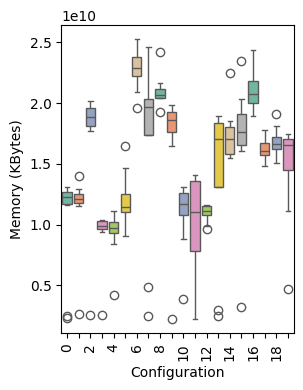

In [76]:
# Paths
experiment_run = ["small_map", "default", "large_map"]
components = ["controller", "planner"]
prefix_f = {"small_map": "data/greenros_reconf_world_small_voxel/",
            "default": "data/greenros_reconf_world_small_fix_config/",
            "large_map": "data/greenros_reconf_world_large/"}
d_folder = "./graphs/"

for prefix_graph in experiment_run:
    prefix = prefix_f[prefix_graph]
    s_folder = prefix_f[prefix_graph]
    std_folder = s_folder
    # Ensure the output folder exists
    os.makedirs(d_folder, exist_ok=True)

    # Load Runtable
    load = LoadData(num_rows=175, s_folder=s_folder, algo="all")
    
    for component in components:
        print(f"Generating boxplot for {component} - {prefix_graph}")
        # Power Boxplot
        gen_power_boxplot(component=component, group_by="configuration", filter=None, transform=False, outliers=True)
        # Machine Power Boxplot
        gen_machine_power_boxplot(group_by="configuration", filter=None, transform=False, outliers=True)
        # Machine CPU Boxplot
        gen_machine_cpu_boxplot(group_by="configuration", filter=None, transform=False, outliers=True)
        # Machine Mem Boxplot
        gen_machine_mem_boxplot(group_by="configuration", filter=None, transform=False, outliers=True)
        # Nav2 Time Boxplot
        gen_nav_time_boxplot(component=component, group_by="configuration", filter=None, outliers=True)
        # Nav2 Recoveries Boxplot
        gen_nav_recoveries(component=component, group_by="configuration", filter=None, outliers=True)
        # Nav2 Path Length Boxplot
        gen_nav_path_boxplot(component=component, group_by="configuration", filter=None, outliers=True)
        # Nav2 Success Percentage Barplot
        gen_nav2_success_percentage_barplot(component=component, group_by="configuration", filter=None, outliers=True)
        # Energy Consumption Barplot
        gen_energy_barplot(group_by="configuration", filter=None, outliers=True, transform=False,
                       outfile=f"barplot_{prefix_graph}_energy.pdf", load=load)
        # Energy Consumption Boxplot
        gen_energy_boxplot(group_by="configuration", filter=None, outliers=True, transform=False,
                       outfile=f"boxplot_{prefix_graph}_energy.pdf", load=load)
        # Machine Energy Consumption Barplot
        gen_machine_energy_barplot(group_by="configuration", filter=None, outliers=True, transform=False,
                       outfile=f"barplot_{prefix_graph}_machine_energy.pdf", load=load)
        # Machine Energy Consumption Boxplots
        gen_machine_energy_boxplot(group_by="configuration", filter=None, outliers=True, transform=False,
                       outfile=f"boxplot_{prefix_graph}_machine_energy.pdf", load=load)

